# Learned data fusion

In [1]:
import os
import cv2
import sys
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib as mp
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from torchsummary import summary
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import distance_transform_edt
from scipy.interpolate import NearestNDInterpolator

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## DataLoader

In [3]:
"""
    KITTI Road dataset with camera and LiDAR fusion
        
    Args:
        data_dir: Path to KITTI dataset
        split: 'training', 'validation' or testing'
        img_height, img_width: Target image dimensions
"""
class KITTIFusionDataset(Dataset):
    def __init__(self, data_dir, split='training', img_height=256, img_width=512):
        self.data_dir = Path(data_dir)
        self.split = split
        self.img_height = img_height
        self.img_width = img_width
        
        # Define paths
        self.image_dir = self.data_dir / 'Kitti_road' / split / 'image_2'
        self.lidar_dir = self.data_dir / 'Kitti_road' / split / 'velodyne'
        self.label_dir = self.data_dir / 'Kitti_road' / split / 'gt_image_2'
        self.calib_dir = self.data_dir / 'Kitti_road' / split / 'calib'
        
        # Get file list
        self.samples = sorted([f.stem for f in self.image_dir.glob('*.png')])
        
        print(f"Found {len(self.samples)} samples in {split} set")
    
    def __len__(self):
        return len(self.samples)

    """
        Load calibration matrices from file

        Args: 
            sample_name: name/identifier of the loaded sample/image/point-cloud
    """
    def load_calibration(self, sample_name):
        calib_file = self.calib_dir / f"{sample_name}.txt"
        
        if not calib_file.exists():
            raise FileNotFoundError(f"Calibration file not found: {calib_file}")
        
        calib_data = {}
        
        with open(calib_file, 'r') as f:
            for line in f:
                line = line.strip()
                if not line or ':' not in line:
                    continue
                
                key, value = line.split(':', 1)
                key = key.strip()
                value = value.strip()

                # Only parse if there's data after the colon
                if value:
                    values = np.array([float(x) for x in value.split()])
                    calib_data[key] = values
        
        # Extract P2 projection matrix (3x4)
        if 'P2' in calib_data:
            P2 = calib_data['P2'].reshape(3, 4)
        else:
            raise ValueError(f"P2 not found in calibration file: {calib_file}")
        
        # Extract R0_rect (3x3) and convert to 4x4
        if 'R0_rect' in calib_data:
            R0_rect = np.eye(4)
            R0_rect[:3, :3] = calib_data['R0_rect'].reshape(3, 3)
        else:
            raise ValueError(f"R0_rect not found in calibration file: {calib_file}")
        
        # Extract Tr_velo_to_cam (3x4) and convert to 4x4
        if 'Tr_velo_to_cam' in calib_data:
            Tr_velo_to_cam = np.eye(4)
            Tr_velo_to_cam[:3, :] = calib_data['Tr_velo_to_cam'].reshape(3, 4)
        else:
            raise ValueError(f"Tr_velo_to_cam not found in calibration file: {calib_file}")
        
        return P2, R0_rect, Tr_velo_to_cam    

    """
        Project 3D LiDAR points to 2D image plane

        Args:
            points: LiDAR pointcloud (N, 4) [x, y, z, intensity]
            P2: projection matrix (image plane)
            R0_rect: projection matrix (rectified camera coordinates)
            Tr_velo_to_cam: projection matrix (velodyne to camera projection matrix)
            image_shape: Target image dimensions (height and width)

        return:
            points_img: point-cloud projected into image plane (N, 3) without intensity
            pixel_coords: (x,y) coordinates of each LiDAR point
            depths: depth value of each LiDAR point
            valid_indices: indices of the LiDAR points that are valid points on the image plane
    """
    def project_lidar_to_image(self, points, P2, R0_rect, Tr_velo_to_cam, image_shape):
        # Transform to homogeneous coordinates
        points_hom = np.hstack([points[:, :3], np.ones((points.shape[0], 1))])
        
        # Transform: velodyne -> camera -> image
        points_cam = (R0_rect @ Tr_velo_to_cam @ points_hom.T).T
        
        # Remove points behind camera
        mask = points_cam[:, 2] > 0
        points_cam = points_cam[mask]
        indices_after_behind = np.where(mask)[0]
        
        # Project to image plane
        points_img = (P2 @ points_cam.T).T
        points_img[:, :2] /= points_img[:, 2:3]

        pixel_coords = points_img[:, :2]
        depths = points_cam[:, 2]

        height, width = image_shape
        valid_mask = (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < width) & \
               (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < height)
        
        points_img = points_img[valid_mask]
        pixel_coords = pixel_coords[valid_mask]
        depths = depths[valid_mask]
        valid_indices = indices_after_behind[valid_mask]
        
        return points_img, pixel_coords, depths, valid_indices


    """
        Densify sparse LiDAR points to create dense depth map
        Only fills regions where LiDAR actually detected points (no artificial top regions like sky)
        
        Args:
            points_2d: (N, 2) projected points [u, v]
            values: (N, 3) values [depth, x, y] for each point
            img_shape: (H, W) target image shape
            max_distance: maximum distance (in pixels) for interpolation
        
        Returns:
            Dense tensor of shape (3, H, W) with [depth, x, y] channels
    """
    def densify_lidar(self, points_2d, values, img_shape, max_distance=4):
        height, width = img_shape
        # Initialize dense map with zeros
        dense_map = np.zeros((3, height, width), dtype=np.float32)


        # Create a sparse representation first
        points_int = points_2d.astype(int)
        for pt, val in zip(points_int, values):
            if 0 <= pt[1] < height and 0 <= pt[0] < width:
                if np.isfinite(val).all():
                    dense_map[:, pt[1], pt[0]] = val
        
        # Create a mask of where we have LiDAR points
        lidar_mask = (dense_map[0] > 0).astype(np.uint8)
        
        # Compute distance from nearest LiDAR point for each pixel
        distance_map = distance_transform_edt(1 - lidar_mask)
        
        # Only interpolate in regions close to actual measurements
        interpolation_mask = distance_map <= max_distance
        
        if interpolation_mask.sum() > len(values):
            # Get coordinates where we want to interpolate
            y_coords, x_coords = np.where(interpolation_mask)
            query_points = np.column_stack([x_coords, y_coords])
            
            # Interpolate each channel only in valid regions
            for i in range(3):
                try:
                    # Check if we have valid values for this channel
                    channel_values = values[:, i]
                    if not np.isfinite(channel_values).all():
                        continue
                    # Use nearest neighbor interpolation in local regions
                    interp = NearestNDInterpolator(points_2d, values[:, i])
                    interpolated = interp(query_points)

                    # Check for NaN in interpolated values
                    if np.isfinite(interpolated).all():
                        # Assign interpolated values
                        dense_map[i, y_coords, x_coords] = interpolated
                    else:
                        # Replace NaN with 0
                        interpolated = np.nan_to_num(interpolated, nan=0.0)
                        dense_map[i, y_coords, x_coords] = interpolated
                except:
                    # If interpolation fails, skip this channel
                    print(f"Warning: Interpolation failed for channel {i}: {e}")
                    continue
        
        # Apply Gaussian smoothing only to filled regions for better visualization
        for i in range(3):
            # Check for NaN values before creating mask
            if not np.isfinite(dense_map[i]).all():
                dense_map[i] = np.nan_to_num(dense_map[i], nan=0.0)
                
            valid_mask = dense_map[i] > 0
            if valid_mask.any():
                try:
                    smoothed = gaussian_filter(dense_map[i], sigma=1.0)
                    # Ensure smoothed values are finite
                    if np.isfinite(smoothed).all():
                        dense_map[i] = np.where(valid_mask, smoothed, 0)
                except Exception as e:
                    print(f"Warning: Gaussian smoothing failed for channel {i}: {e}")
                    continue

        # Final check: replace any remaining NaN or inf values with 0
        dense_map = np.nan_to_num(dense_map, nan=0.0, posinf=0.0, neginf=0.0)
        
        return dense_map

    """
        Rotate image, 2D LiDAR projections, and label together
    
        Args:
            image: (H, W, 3) RGB image
            lidar_points_2d: (N, 2) projected LiDAR points [u, v]
            lidar_values: (N, 3) corresponding [depth, x, y] values
            label: (H, W) segmentation mask
            angle_degrees: rotation angle in degrees

        return:
            image_rotated: rotated image
            lidar_rotated_2d: rotated projected LiDAR points
            lidar_values: LiDAR point-cloud masked to remove out of images points 
            label_rotated: rotated label      
    """
    def rotate_image_and_lidar(self, image, lidar_points_2d, lidar_values, label, angle_degrees):
        H, W = image.shape[:2]
        center = (W / 2, H / 2)
        
        # Get rotation matrix for image
        rot_matrix = cv2.getRotationMatrix2D(center, angle_degrees, scale=1.0)
        
        # Rotate image
        image_rotated = cv2.warpAffine(image, rot_matrix, (W, H))
        
        # Rotate label
        label_rotated = cv2.warpAffine(label, rot_matrix, (W, H))
        
        # Rotate 2D LiDAR points
        # Convert to homogeneous coordinates
        ones = np.ones((lidar_points_2d.shape[0], 1))
        lidar_homogeneous = np.hstack([lidar_points_2d, ones])
        
        # Apply 2D rotation
        lidar_rotated_2d = (rot_matrix @ lidar_homogeneous.T).T
        
        # Filter points that are still within bounds
        mask = (lidar_rotated_2d[:, 0] >= 0) & (lidar_rotated_2d[:, 0] < W) & \
               (lidar_rotated_2d[:, 1] >= 0) & (lidar_rotated_2d[:, 1] < H)
        
        lidar_rotated_2d = lidar_rotated_2d[mask]
        lidar_values = lidar_values[mask]
        
        return image_rotated, lidar_rotated_2d, lidar_values, label_rotated

    """
        Get a sample of image, LiDAR, label and sample_name
    """
    def __getitem__(self, idx):
        sample_name = self.samples[idx]
        
        # Load RGB image
        img_path = self.image_dir / f"{sample_name}.png"
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = image.shape[:2]
        
        # Resize image
        image = cv2.resize(image, (self.img_width, self.img_height))
        image = image.astype(np.float32) / 255.0
        
        # Load label (for road segmentation)
        sample_name_label = sample_name.split("_")
        label_path = self.label_dir / f"{sample_name_label[0]}_road_{sample_name_label[1]}.png"
        if label_path.exists():
            label = cv2.imread(str(label_path))
            label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
            label = cv2.resize(label, (self.img_width, self.img_height))
            label = np.transpose(label, (2, 0, 1)) # (C, H, W)
            label = (label[2] > 0).astype(np.float32)
        elif self.split == "training" or self.split == "validation":
            raise ValueError(f"labeled image not found in: {label_path}")
        else:
            label = np.zeros((self.img_height, self.img_width), dtype=np.float32)

        # Load LiDAR points
        lidar_path = self.lidar_dir / f"{sample_name}.bin"
        if lidar_path.exists():
            points = np.fromfile(str(lidar_path), dtype=np.float32).reshape(-1, 4)
        else:
            raise ValueError(f"lidar point cloud not found in: {lidar_pathpath}")
        
        # Load calibration
        P2, R0_rect, Tr_velo_to_cam = self.load_calibration(sample_name)

        # Scale projection to resized image
        scale_x = self.img_width / orig_w
        scale_y = self.img_height / orig_h

        # Create scaling matrix for the projection
        scale_matrix = np.array([
            [scale_x, 0, 0],
            [0, scale_y, 0],
            [0, 0, 1]
        ])
        
        # Scale the projection matrix
        P2_scaled = scale_matrix @ P2
        
        # Project LiDAR to image
        points_img, pixel_coords, depths, valid_indices = self.project_lidar_to_image(points, P2_scaled, R0_rect, Tr_velo_to_cam, (self.img_height, self.img_width))

        x = pixel_coords[:, 0]
        y = pixel_coords[:, 1]
    
        values = np.stack([depths, x, y], axis=1)

         
        if self.split == "training":
            random_rotation_angle = random.randint(-20, 20)
            image, pixel_coords, values, label = self.rotate_image_and_lidar(image, pixel_coords, values, label, random_rotation_angle)
        
        image = np.transpose(image, (2, 0, 1))
        label = torch.from_numpy(label).unsqueeze(0)
        
        # Densify LiDAR data
        lidar_dense = self.densify_lidar(pixel_coords, values, (self.img_height, self.img_width))

        return {
            'image': torch.FloatTensor(image),
            'lidar': torch.FloatTensor(lidar_dense),
            'label': torch.FloatTensor(label),
            'name': sample_name
        }

### Dataloading test

In [4]:
"""
    Defining the train dataset
"""
dataset_train = KITTIFusionDataset(data_dir = "/kaggle/input/kitti-road", split = "training", img_width = 1024, img_height = 320)

Found 238 samples in training set


In [5]:
"""
    Defining the train dataloader
"""
dataloader_train = DataLoader(dataset=dataset_train, batch_size=4, shuffle=True, num_workers=1)

In [6]:
"""
    Getting a batch from the dataloader
"""
data = next(iter(dataloader_train))

In [7]:
"""
    Retrieving and printing the batch's first sample
"""
image = data['image'][0]
lidar = data['lidar'][0]
label = data['label'][0]
name = data['name'][0]

print(image.shape)
print(lidar.shape)
print(label.shape)
print(name)

torch.Size([3, 320, 1024])
torch.Size([3, 320, 1024])
torch.Size([1, 320, 1024])
umm_000094


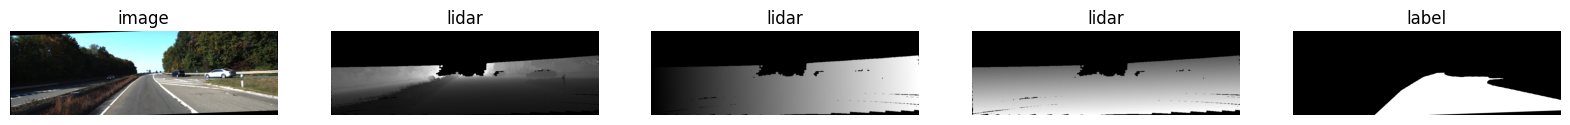

In [8]:
"""
    Printing the sample's images
"""

image_1 = image.permute(1, 2, 0).numpy()
label_1 = label.permute(1, 2, 0).numpy()

plt.figure(figsize=(20, 15))


plt.subplot(1, 5, 1)
plt.imshow(image_1)
plt.title("image")
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(lidar[0], cmap="gray")
plt.title("lidar")
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(lidar[1], cmap="gray")
plt.title("lidar")
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(lidar[2], cmap="gray")
plt.title("lidar")
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(label_1, cmap="gray")
plt.title("label")
plt.axis("off")

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

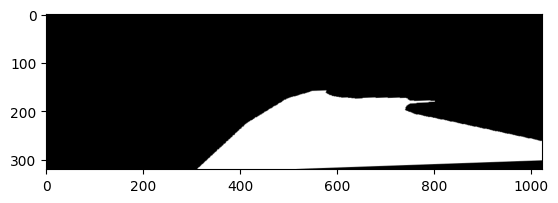

In [9]:
"""
    Zoom on the sample's label
"""
plt.imshow(label_1, cmap="gray")
plt.show

## Network

### Cross fusion block

In [10]:
"""
    Definition of the CrossFusion module that contains the learnable parameters
    alpha and beta used to cross-fuse the LiDAR and the camera network branches
"""
class CrossFusion(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.alpha = nn.Parameter(torch.zeros(1, channels, 1, 1))
        self.beta  = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, f_rgb, f_lidar):
        f_rgb_new   = f_rgb   + self.alpha * f_lidar
        f_lidar_new = f_lidar + self.beta  * f_rgb
        return f_rgb_new, f_lidar_new


### Convolutional blocks

In [11]:
"""
    Definition of all the convolutional/deconvolutional blocks that are going to be used in the network
"""
def conv3x3(in_c, out_c, kernel_size=3, stride=1, padding=1, dilation=1, dropout=0.0):
    layers = [
        nn.Conv2d(in_c, out_c, kernel_size, stride=stride, padding=padding, dilation=dilation),
        nn.ELU(inplace=True)
    ]

    if dropout > 0.0:
        layers.append(nn.Dropout(p=dropout))
        
    return nn.Sequential(*layers)
    
def conv4x4(in_c, out_c, stride=2):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, 4, stride=stride, padding=1),
        nn.ELU(inplace=True)
    )

def deconv4x4(in_c, out_c):
    return nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, 4, stride=2, padding=1),
        nn.ELU(inplace=True)
    )


### Context module

In [12]:
"""
    Definition of the context module of the network
"""
class ContextModule(nn.Module):
    def __init__(self, channels=128):
        super().__init__()
        self.layers = nn.ModuleList([
            conv3x3(channels, channels, padding="same", dilation=1, dropout=0.25),
            conv3x3(channels, channels, padding="same", dilation=1, dropout=0.25),
            conv3x3(channels, channels, padding="same", dilation=(1,2), dropout=0.25),
            conv3x3(channels, channels, padding="same", dilation=(2,4), dropout=0.25),
            conv3x3(channels, channels, padding="same", dilation=(4,8), dropout=0.25),
            conv3x3(channels, channels, padding="same", dilation=(8,16), dropout=0.25),
            conv3x3(channels, channels, padding="same", dilation=(16,32), dropout=0.25),
            conv3x3(channels, channels, padding="same", dilation=1, dropout=0.25),
            conv3x3(channels, channels, kernel_size=1, padding="same", dropout=0.25)
        ])

        self.cross_fusion = nn.ModuleList([
            CrossFusion(channels) for _ in range(9)
        ])

    def forward(self, f_rgb, f_lid):
        for conv, fusion in zip(self.layers, self.cross_fusion):
            f_rgb = conv(f_rgb)
            f_lid = conv(f_lid)

            f_rgb, f_lid = fusion(f_rgb, f_lid)

        return f_rgb, f_lid


### Final network

In [13]:
"""
    Final network definition
"""
class CrossFusionFCN(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        # ========== ENCODER =============

        self.enc1_rgb = conv4x4(3, 32)
        self.enc1_lid = conv4x4(3, 32)
        self.fuse1    = CrossFusion(32)

        self.enc2_rgb = conv3x3(32, 32)
        self.enc2_lid = conv3x3(32, 32)
        self.fuse2    = CrossFusion(32)

        self.enc3_rgb = conv4x4(32, 64)
        self.enc3_lid = conv4x4(32, 64)
        self.fuse3    = CrossFusion(64)

        self.enc4_rgb = conv3x3(64, 64)
        self.enc4_lid = conv3x3(64, 64)
        self.fuse4    = CrossFusion(64)

        self.enc5_rgb = conv4x4(64, 128)
        self.enc5_lid = conv4x4(64, 128)
        self.fuse5    = CrossFusion(128)

        # ========== CONTEXT =============
        self.context = ContextModule(128)

        # ========== DECODER =============
        self.dec1_rgb = deconv4x4(128, 64)
        self.dec1_lid = deconv4x4(128, 64)
        self.fuse6    = CrossFusion(64)

        self.dec2_rgb = conv3x3(64, 64)
        self.dec2_lid = conv3x3(64, 64)
        self.fuse7    = CrossFusion(64)

        self.dec3_rgb = deconv4x4(64, 32)
        self.dec3_lid = deconv4x4(64, 32)
        self.fuse8    = CrossFusion(32)

        self.dec4_rgb = conv3x3(32, 32)
        self.dec4_lid = conv3x3(32, 32)
        self.fuse9    = CrossFusion(32)

        self.dec5_rgb = deconv4x4(32, 8)
        self.dec5_lid = deconv4x4(32, 8)
        self.fuse10    = CrossFusion(8)

        self.final = nn.Conv2d(8, num_classes, 3, padding=1)

    def forward(self, rgb, lidar):

        # Encoder
        f1_rgb = self.enc1_rgb(rgb)
        f1_lid = self.enc1_lid(lidar)
        f1_rgb, f1_lid = self.fuse1(f1_rgb, f1_lid)

        f2_rgb = self.enc2_rgb(f1_rgb)
        f2_lid = self.enc2_lid(f1_lid)
        f2_rgb, f2_lid = self.fuse2(f2_rgb, f2_lid)

        f3_rgb = self.enc3_rgb(f2_rgb)
        f3_lid = self.enc3_lid(f2_lid)
        f3_rgb, f3_lid = self.fuse3(f3_rgb, f3_lid)

        f4_rgb = self.enc4_rgb(f3_rgb)
        f4_lid = self.enc4_lid(f3_lid)
        f4_rgb, f4_lid = self.fuse4(f4_rgb, f4_lid)

        f5_rgb = self.enc5_rgb(f4_rgb)
        f5_lid = self.enc5_lid(f4_lid)
        f5_rgb, f5_lid = self.fuse5(f5_rgb, f5_lid)

        # Context
        fC_rgb, fC_lid = self.context(f5_rgb, f5_lid)

        # Decoder
        d1_rgb = self.dec1_rgb(fC_rgb)
        d1_lid = self.dec1_lid(fC_lid)
        d1_rgb, d1_lid = self.fuse6(d1_rgb, d1_lid)

        d2_rgb = self.dec2_rgb(d1_rgb)
        d2_lid = self.dec2_lid(d1_lid)
        d2_rgb, d2_lid = self.fuse7(d2_rgb, d2_lid)

        d3_rgb = self.dec3_rgb(d2_rgb)
        d3_lid = self.dec3_lid(d2_lid)
        d3_rgb, d3_lid = self.fuse8(d3_rgb, d3_lid)

        d4_rgb = self.dec4_rgb(d3_rgb)
        d4_lid = self.dec4_lid(d3_lid)
        d4_rgb, d4_lid = self.fuse9(d4_rgb, d4_lid)

        d5_rgb = self.dec5_rgb(d4_rgb)
        d5_lid = self.dec5_lid(d4_lid)
        d5_rgb, d5_lid = self.fuse10(d5_rgb, d5_lid)

        # Final fusion
        fused = d5_rgb + d5_lid

        out = self.final(fused)
        return out


In [14]:
"""
    Utility cell to see the network parameters
"""
### Initializing the model
model = CrossFusionFCN(num_classes = 1).to(device)

# Printing the model architecture and number of parameters
summary(model, [(3, 320, 1024),(3, 320, 1024)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 512]           1,568
               ELU-2         [-1, 32, 160, 512]               0
            Conv2d-3         [-1, 32, 160, 512]           1,568
               ELU-4         [-1, 32, 160, 512]               0
       CrossFusion-5  [[-1, 32, 160, 512], [-1, 32, 160, 512]]               0
            Conv2d-6         [-1, 32, 160, 512]           9,248
               ELU-7         [-1, 32, 160, 512]               0
            Conv2d-8         [-1, 32, 160, 512]           9,248
               ELU-9         [-1, 32, 160, 512]               0
      CrossFusion-10  [[-1, 32, 160, 512], [-1, 32, 160, 512]]               0
           Conv2d-11          [-1, 64, 80, 256]          32,832
              ELU-12          [-1, 64, 80, 256]               0
           Conv2d-13          [-1, 64, 80, 256]          32,832
         

## Network parameters

In [15]:
# Hyperparameters definition
EPOCHS = 100
BATCH_SIZE = 1
LR = 0.0005
N = 100000
alpha = 0.9

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Adaptive learning rate definition
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i: (1 - i / N) ** alpha
)

## Training

In [16]:
"""
    Defining the train dataset
"""
dataset_train = KITTIFusionDataset(data_dir = "/kaggle/input/kitti-road", split = "training", img_width = 1024, img_height = 320)

Found 238 samples in training set


In [17]:
"""
    Defining the train dataloader
"""
dataloader_train = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [18]:
"""
    Network training
"""
cross_losses = []
model.train()
for epoch in range(EPOCHS):
    epoch_losses = 0.0
    for i, batch in enumerate(dataloader_train):
        images = batch['image'].to(device)
        lidars = batch['lidar'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(images, lidars)

        # Compute loss
        loss = criterion(outputs, labels)
        epoch_losses += loss.item() * images.size(0)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update learning rate
        scheduler.step()

        # Printing loss of each batch
        print(f'EPOCH#{epoch},\t Batch#{i},\t Loss:{loss.item()}')
    cross_losses.append(epoch_losses / len(dataloader_train.dataset))

EPOCH#0,	 Batch#0,	 Loss:0.6890280246734619
EPOCH#0,	 Batch#1,	 Loss:0.6802718043327332
EPOCH#0,	 Batch#2,	 Loss:0.6773826479911804
EPOCH#0,	 Batch#3,	 Loss:0.6517601013183594
EPOCH#0,	 Batch#4,	 Loss:0.6035383343696594
EPOCH#0,	 Batch#5,	 Loss:0.5577137470245361
EPOCH#0,	 Batch#6,	 Loss:0.406881183385849
EPOCH#0,	 Batch#7,	 Loss:0.40112200379371643
EPOCH#0,	 Batch#8,	 Loss:0.30656033754348755
EPOCH#0,	 Batch#9,	 Loss:0.48602333664894104
EPOCH#0,	 Batch#10,	 Loss:0.4306406080722809
EPOCH#0,	 Batch#11,	 Loss:0.3227047622203827
EPOCH#0,	 Batch#12,	 Loss:0.2647155821323395
EPOCH#0,	 Batch#13,	 Loss:0.5510047078132629
EPOCH#0,	 Batch#14,	 Loss:0.27660509943962097
EPOCH#0,	 Batch#15,	 Loss:0.2723734378814697
EPOCH#0,	 Batch#16,	 Loss:0.2672432065010071
EPOCH#0,	 Batch#17,	 Loss:0.23770053684711456
EPOCH#0,	 Batch#18,	 Loss:0.20124824345111847
EPOCH#0,	 Batch#19,	 Loss:0.26464352011680603
EPOCH#0,	 Batch#20,	 Loss:0.15479232370853424
EPOCH#0,	 Batch#21,	 Loss:0.26548948884010315
EPOCH#0,	 Ba

### Training losses

[0.23031495893452347, 0.16878695476080188, 0.1550984898222094, 0.14693428740343628, 0.14967950151748016, 0.13563057362344585, 0.12518464269883492, 0.11022615464044218, 0.10028915713001199, 0.0981205910162515, 0.09326624720819107, 0.09183058549626534, 0.08478384575329158, 0.08011374211705782, 0.08512542246520019, 0.07742409788447768, 0.06982084799620535, 0.0715055892071804, 0.06859923820128712, 0.07038898802041507, 0.06494863874850278, 0.05760841108389011, 0.05938410702623239, 0.0562767361783806, 0.057343008818433565, 0.08265451291388198, 0.05697562024310356, 0.05390316128981214, 0.05089210860133797, 0.046040377121794374, 0.046717338256162255, 0.04483061115953978, 0.044014117997452744, 0.042692060003197994, 0.04154471103728068, 0.04395660983414209, 0.03830384381287614, 0.04055852714550345, 0.03930190974502128, 0.0401571988237693, 0.06434618880847047, 0.054168680009721706, 0.04264183205497615, 0.03835475034307407, 0.03613945780744573, 0.03460118438688522, 0.0363578888305909, 0.0355299409

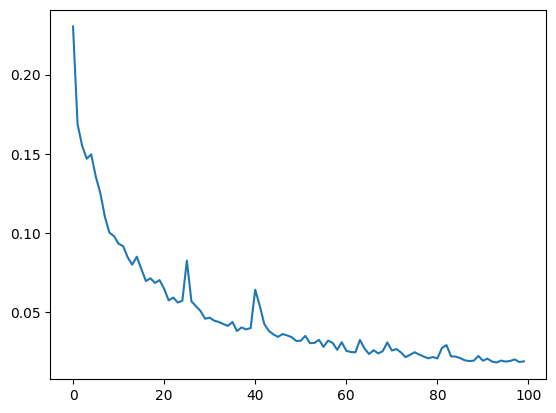

In [19]:
# Plot to see the evolution of the loss during the training
print(cross_losses)
plt.plot(np.arange(len(cross_losses)), cross_losses)

### Save/Load network weights

In [20]:
# Save the model
PATH = '/kaggle/working/Cross_fusion_KITTI.pth'
torch.save(model.state_dict(), PATH)

In [21]:
# Load the model
#PATH = '/kaggle/input/training/pytorch/default/1/Cross_fusion_KITTI.pth'
#model.load_state_dict(torch.load(PATH, device))

## Evaluation

In [22]:
"""
    Defining the validation dataset
"""
dataset_validation = KITTIFusionDataset(data_dir = "/kaggle/input/kitti-road", split = "validation", img_width = 1024, img_height = 320)

Found 51 samples in validation set


In [23]:
"""
    Defining the validation dataloader
"""
dataloader_validation = DataLoader(dataset=dataset_validation, batch_size=4, shuffle=False, num_workers=4)

In [24]:
"""
    Defining the validation shuffled dataloader
"""
shuffled_dataloader_validation = DataLoader(dataset=dataset_validation, batch_size=4, shuffle=True, num_workers=4)

In [25]:
# Function to compute the Intersection over Union rate
'''
Takes as input:
    pred: tensor [B, C, H, W] -> output raw logits of the model
    target: tensor [B, H, W] -> ground truth (binary mask)

Return:
    mean IoU
'''
def compute_iou_torch(pred, target, threshold=0.5, eps=1e-6):
    pred = torch.sigmoid(pred)

    # Binarization
    pred = (pred > threshold).float()
    target = (target > 0.5).float()
    
    # Intersection & Union
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - intersection

    iou = (intersection + eps) / (union + eps)
    return iou.mean()


### IoU

In [26]:
"""
    Computing the IoU for the validation dataset
"""

# Putting the model in evaluation mode
model.eval()
num_batches = 0
total_iou = 0

with torch.no_grad():
    for batch in tqdm(dataloader_validation, desc="IoU", total=len(dataloader_validation), unit="batch"):
        images = batch['image'].to(device)
        lidars = batch['lidar'].to(device)
        labels = batch['label'].to(device)

        outputs = model(images, lidars)
        
        # IoU computation
        mean_iou = compute_iou_torch(outputs, labels).item()
        total_iou += mean_iou
        
        num_batches += 1

mean_iou_final = (total_iou / num_batches)
print(f"Final mean IoU: {mean_iou_final:.4f}")

IoU: 100%|██████████| 13/13 [00:14<00:00,  1.12s/batch]

Final mean IoU: 0.8741


### Visual result presentation 

In [27]:
"""
    Add a green overlay to background_img defined by predicted image

    Args:
        background_img: image to be overlayed
        predicted: image containing the overlay
        transparency: transparency of the applied overlay
        
    return:
        The image overlayed
"""
def compute_overlay(background_img, predicted, transparency = 0.5):
    # Green overlay
    overlay = background_img.copy()
    overlay[..., 1] = np.maximum(overlay[..., 1], predicted)

    # Blend
    blended = (1 - transparency) * background_img + transparency * overlay
    blended = blended.astype(np.uint8)
    return overlay

In [28]:
"""
    Plot the images passed as input

    Args:
        display_list: contains the original image, the ground thruth mask, the predicted mask

    return:
        plt: the created plot
"""
def display(display_list):
    plt.figure(figsize=(20, 15))

    img = display_list[0].permute(1, 2, 0).numpy()
    gt = display_list[1].permute(1, 2, 0).numpy()
    predicted = display_list[2]
    overlay = compute_overlay(img, predicted)

    title = ['Input Image', 'True Mask', 'Predicted Mask', 'Mask overlay']

    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title(title[0])
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gt, cmap="gray")
    plt.title(title[1])
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(predicted.permute(1, 2, 0).numpy(), cmap="gray")
    plt.title(title[2])
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.title(title[3])
    plt.axis('off')
    
    return plt

In [29]:
"""
    Conversion of the output logits to classes

    Args:
        pred_mask: logits produced by the network as output

    return:
        pred_bin: a binary mask representing the logits 
"""
def create_mask(pred_mask):
    probs = torch.sigmoid(pred_mask).detach()
    pred_bin = (probs > 0.5).float()
    return pred_bin

In [30]:
"""
    Display the first image of a number of batches enclosed 
    with the ground thruth (if present), the network prediction and the overlay (img-predicted)

    Args:
        dataloader: dataloader from which the batches are taken
        device: gpu(cuda) or cpu
        num: number of bathces to extract
"""
def show_predictions(dataloader, device, num=1):
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            # RGB image
            IMG = batch["image"][0, :, : ,:].to(device).unsqueeze(0)
            LIDAR = batch["lidar"][0, :, :, :].to(device).unsqueeze(0)
            # mask
            MASK = batch["label"][0, :, :, :].to(device).unsqueeze(0)
            # LabelIds prediction
            pred_mask = model.to(device)(IMG, LIDAR)
            # Plotting the three images next to each other
            #count_non_zeros(create_mask(pred_mask).cpu()[0])
            display([IMG[0].cpu(), MASK[0].cpu(), create_mask(pred_mask).cpu()[0]]).show()
            if i >= num:
                break

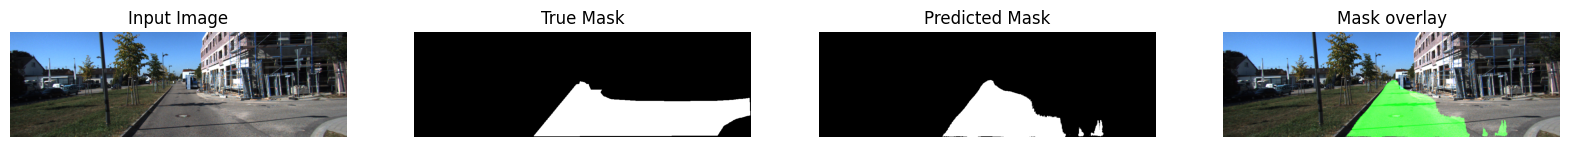

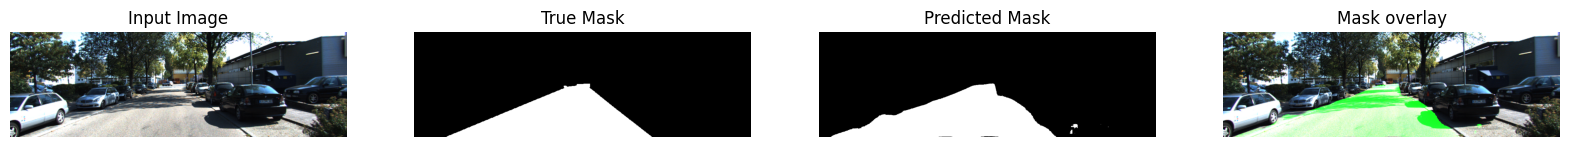

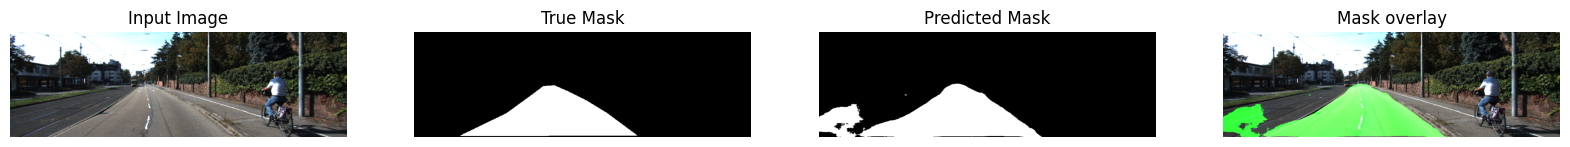

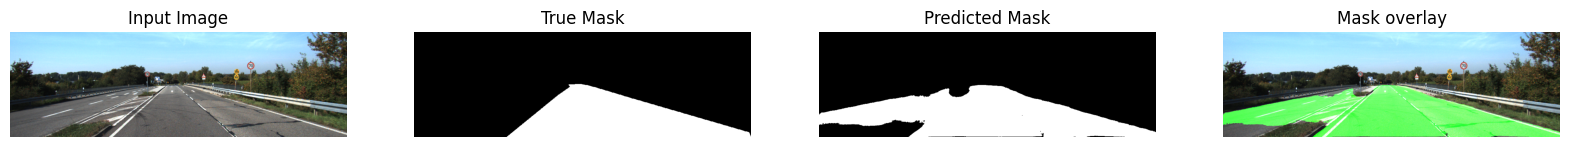

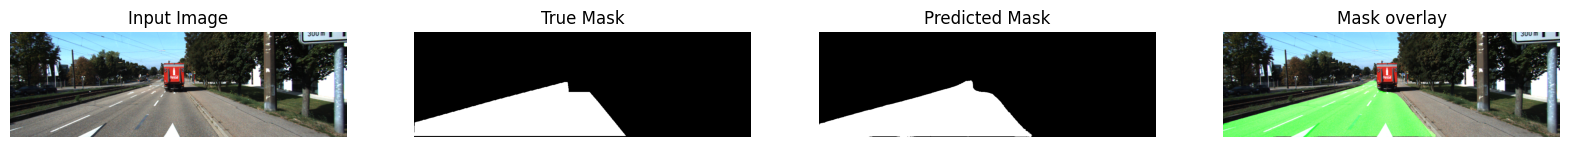

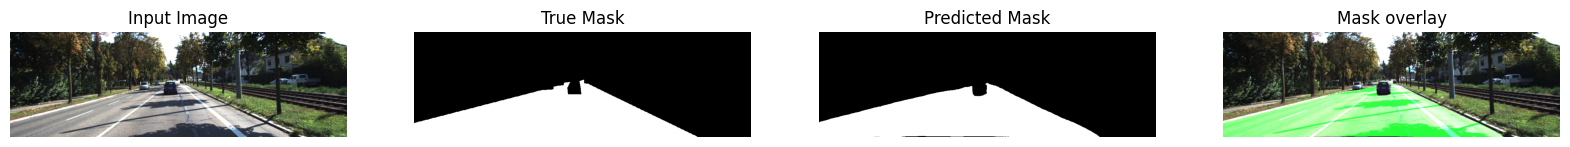

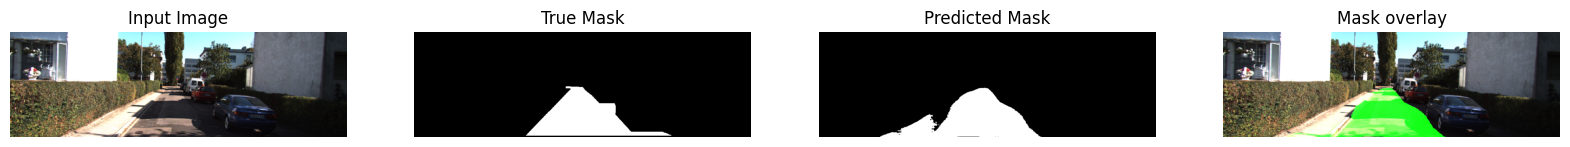

In [31]:
"""
    Showing the network results on the validation dataset
"""
show_predictions(shuffled_dataloader_validation, device, 6)

## Testing

In [32]:
"""
    Defining the testing dataset
"""
dataset_test = KITTIFusionDataset(data_dir = "/kaggle/input/kitti-road", split = "testing", img_width = 1024, img_height = 320)

Found 290 samples in testing set


In [33]:
"""
    Defining the testing dataloader
"""
dataloader_test = DataLoader(dataset=dataset_test, batch_size=4, shuffle=False, num_workers=4)

In [34]:
"""
    Defining the testing shuffled dataloader
"""
shuffled_dataloader_test = DataLoader(dataset=dataset_test, batch_size=4, shuffle=True, num_workers=4)

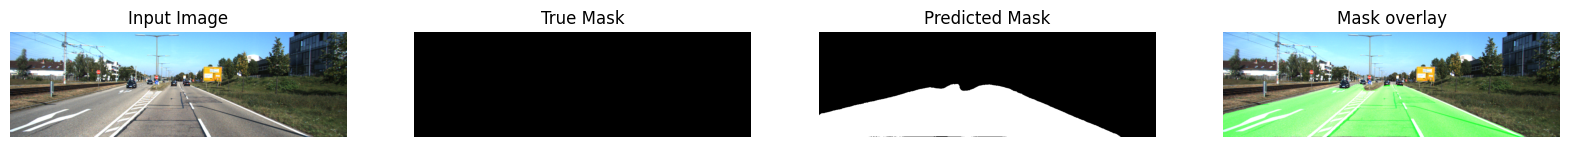

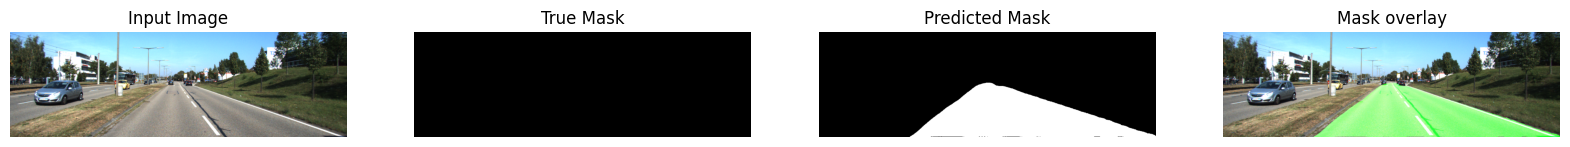

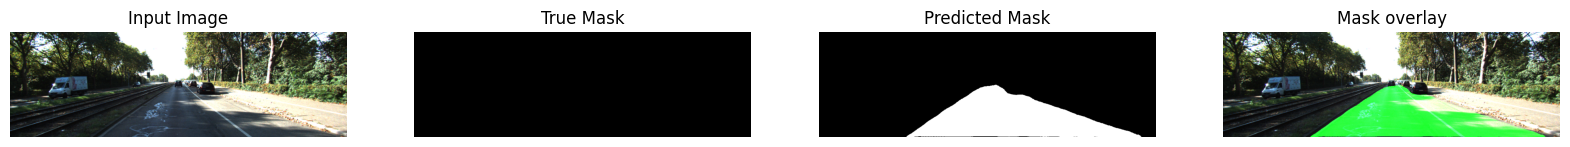

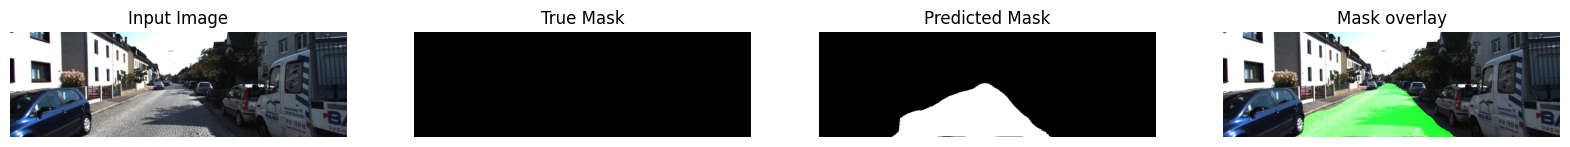

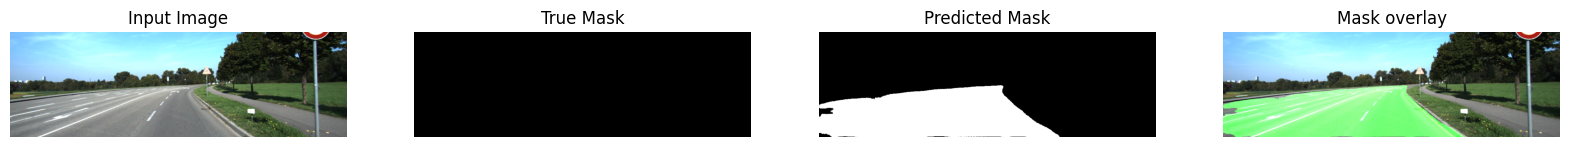

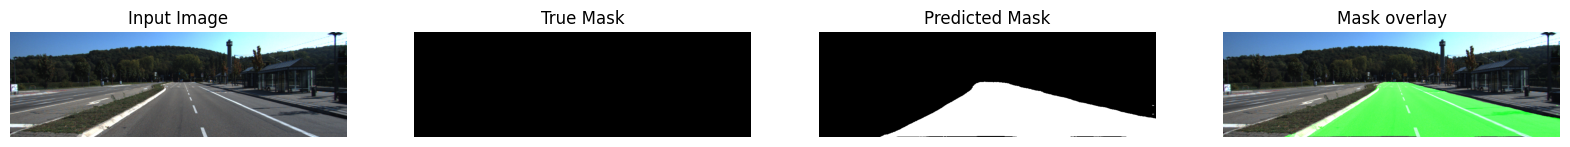

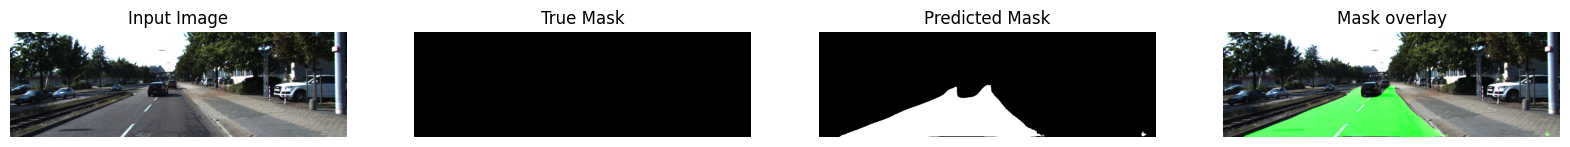

In [35]:
"""
    Showing the network results on the validation dataset
"""
show_predictions(shuffled_dataloader_test, device, 6)